# Implementation of classifier using Naive Bayes.

Import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import re

Dataset consists of 5574 English SMS messages, 425 of them tagged as spam and 3375 tagged as ham.

In [2]:
sms = pd.read_csv("data/spam.csv")
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
sms.shape

(5572, 5)

Removing uninformative columns and renaming the remaining columns relevant names.

In [4]:
sms.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)
sms.rename(columns={"v1": "is_spam", "v2": "message"}, inplace=True)

Сonverting column **is_spam** to numeric data type and converting all words to lower case.

In [5]:
labelencoder = LabelEncoder()
sms.loc[:, "is_spam"] = labelencoder.fit_transform(sms.loc[:, "is_spam"])
sms["message"] = sms["message"].apply(lambda text: text.lower())

In [6]:
targets, texts = sms["is_spam"], sms["message"]

Splitting the texts into separate words.

In [7]:
tokens = texts.apply(lambda text: word_tokenize(text))

Removing stop words that occur in many texts and therefore do not contain a useful signal and allows us to reduce the amount of data for analysis and focus on more relevant words, which increases the accuracy and efficiency of text processing. Removing characters that are not words or letters.

In [8]:
stop_words = set(stopwords.words('english'))
pattern = r"[^a-zA-Z]"

filtered_tokens = tokens.apply(
    lambda text:
    [word for word in text if (word not in stop_words and not re.search(pattern, word))]
)

Compressing the word space using lemmatization that reduces words to their base or dictionary form.

In [9]:
lemmatizer = WordNetLemmatizer()
lemmatized_words = filtered_tokens.apply(
    lambda tokens: [lemmatizer.lemmatize(token) for token in tokens]
)
lemmatized_words.head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3        [u, dun, say, early, hor, u, c, already, say]
4          [nah, think, go, usf, life, around, though]
Name: message, dtype: object

Splitting the data into test and validation.

In [10]:
texts_train, texts_test, y_train, y_test = train_test_split(
    filtered_tokens, targets, test_size=0.2, random_state=42
)

y_train = np.array(y_train)
y_test = np.array(y_test)

Let's count the frequency of words in the test data.

In [11]:
dictionary = {}
for text in texts_train:
    for word in text:
        if word not in dictionary:
            dictionary[word] = 0
        dictionary[word] += 1
        
most_common = sorted(dictionary.values(), reverse=True)

Removing the most frequent words as they carry little useful information. Removing rarely occurring words so that the model does not overfit.

In [12]:
lower_bound = 5
upper_bound = most_common[0]
texts_train = texts_train.apply(
    lambda text: [word for word in text if lower_bound <= dictionary[word] <= upper_bound]
)

texts_train.head()

1978                             [still, check, yo, half]
3989                            [bank, issues, pick, per]
3935                          [r, giving, second, chance]
4078                                             [lt, gt]
4086    [private, account, statement, shows, points, c...
Name: message, dtype: object

Converting data to a numeric type using a tool that counts the number of occurrences of words. Аfter this the document will be a vector showing how many times each word from the dictionary appears in it.

In [13]:
texts_train = texts_train.apply(lambda text: " ".join(text))
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test.apply(lambda text: " ".join(text)))
len(vectorizer.vocabulary_)

1351

The classification will be done using a Naive Bayes classifier, which assumes that all words in the dictionary are conditionally independent given the category. In the text classification paradigm, we assume that different words in a text on the same topic appear independently of each other. 

This notebook implements two approaches to Naive Bayes: multinomial and multivariate. 

- In the multinomial model, a document is a sequence of events that are a random selection of one word from a "bag of words". When we calculate the likelihood of a document, we multiply the probabilities that we pulled out of the "bag of words" the words that appeared in the document. The result is a model that takes into account the number of times each word appears, but does not take into account which words are not in the document.

- In a multivariate model, a document is a vector of binary attributes indicating whether a particular word occurred in the document. When we calculate the likelihood of a document, we multiply the probabilities of each word in the document occurring and also with multiply the probabilities of each word in the dictionary not occurring.

In [14]:
class NaiveBayes:
    def __init__(self, mode):
        self.mode = mode
        self.classes = None 
        self.log_priors = None
        self.likelihood = None
        
    def fit(self, X, y):
        num_samples = X.shape[0]
        len_voc = X.shape[1]
        self.classes = np.unique(y)
        num_classes = len(self.classes)
        class_cnt = np.unique(y, return_counts=True)[1]
        self.log_priors = np.log((class_cnt + 1) / (num_samples + num_classes))[:,None]
            
        if self.mode == 'multinomial':
            num_words_in_class = np.zeros((num_classes, len_voc))
            for class_num in self.classes:
                X_class = X[np.where(y == class_num)]
                num_words_in_class[class_num, :] = np.sum(X_class, axis=0)
            num_words_in_class_overall = np.sum(num_words_in_class, axis=1)[:,None]

            self.likelihood = np.log(
                (num_words_in_class + 1) / (num_words_in_class_overall + len_voc)
            )
            
        if self.mode == 'multivariate':
            samples_in_class = np.zeros((num_classes, len_voc))
            for i in range(len_voc):
                samples_with_word = np.where(np.squeeze(X[:,i].toarray()) != 0)
                class_docs_with_word = y[samples_with_word]
                samples_in_class[:, i] = (
                    len(class_docs_with_word) - class_docs_with_word.sum(), class_docs_with_word.sum()
                )
                
            self.likelihood = []
            likelihood_pos = np.log((samples_in_class + 1) / (class_cnt[:,None] + 2))
            self.likelihood.append(likelihood_pos)
            likelihood_neg = np.log(1 - (samples_in_class + 1) / (class_cnt[:,None] + 2))
            self.likelihood.append(likelihood_neg)
        
        
    def predict(self, X, y):
        num_samples = X.shape[0]
        num_classes = len(self.classes)
        num_samples = X.shape[0]
        num_classes = len(self.classes)
        posteriors = np.zeros((num_samples, num_classes))
        
        if self.mode == 'multinomial':
            for class_num in self.classes:
                posteriors[:,class_num] = self.log_priors[class_num] + X @ self.likelihood[class_num]
            
        if self.mode == 'multivariate':
            X_pos = np.where(X.toarray() > 0, 1, 0)
            for class_num in self.classes:
                posteriors[:,class_num] = (
                    self.log_priors[class_num] + X_pos @ self.likelihood[0][class_num]
                )
            X_neg = np.where(X.toarray() > 0, 0, 1)
            for class_num in self.classes:
                posteriors[:,class_num] += X_neg @ self.likelihood[1][class_num]

        y_predict = np.argmax(posteriors, axis=1)
        print(f'{self.mode} model:')
        print('accuracy:', f'{accuracy_score(y, y_predict):.3f}')
        print('precision:', f'{precision_score(y, y_predict):.3f}')
        print('recall:', f'{recall_score(y, y_predict):.3f}')
        cm = confusion_matrix(y, y_predict)
        sns.heatmap(cm, annot = True, fmt = 'd', annot_kws={"fontsize":16})
        plt.xlabel('Predicted', fontsize=16)
        plt.ylabel('Actual', fontsize=16);
        
        return y_predict

multinomial model:
accuracy: 0.971
precision: 0.904
recall: 0.880


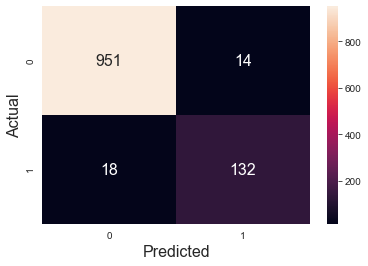

In [15]:
nb = NaiveBayes('multinomial')
nb.fit(X_train, y_train)
y_pred_multinomial = nb.predict(X_test, y_test)

multivariate model:
accuracy: 0.979
precision: 0.985
recall: 0.860


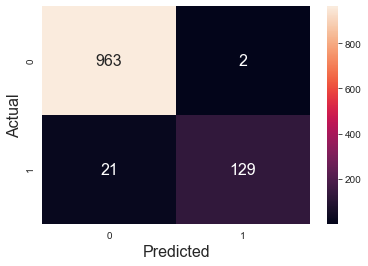

In [16]:
nb = NaiveBayes('multivariate')
nb.fit(X_train, y_train)
y_pred_multivariate = nb.predict(X_test, y_test)

The results show that the multivariate model has higher precision, but lower recall. This is probably due to the fact that those messages that were not spam, but contained words that are often found in spam, are classified correctly by the multivariate model. This became possible due to the consideration of those words that were in the dictionary, but did not appear in the message. Let's find such messages.

In [17]:
idx_1 = np.intersect1d(np.where(y_pred_multinomial == 1), np.where(y_test == 0))
idx_2 = np.intersect1d(np.where(y_pred_multivariate == 1), np.where(y_test == 0))
idx = np.setdiff1d(idx_1, idx_2)
for i in idx:
    print(f'{i}:', texts.iloc[i])

100: okay name ur price as long as its legal! wen can i pick them up? y u ave x ams xx
101: i'm still looking for a car to buy. and have not gone 4the driving test yet.
209: both :) i shoot big loads so get ready!
246: i asked you to call him now ok
268: the evo. i just had to download flash. jealous?
319: coffee cake, i guess...
473: want 2 get laid tonight? want real dogging locations sent direct 2 ur mob? join the uk's largest dogging network by txting moan to 69888nyt. ec2a. 31p.msg@150p
501: when can �_ come out?
567: so anyways, you can just go to your gym or whatever, my love *smiles* i hope your ok and having a good day babe ... i miss you so much already
701: sorry, i'll call later
792: y?where u at dogbreath? its just sounding like jan c that��s al!!!!!!!!!
844: k.k:)when are you going?
845: meanwhile in the shit suite: xavier decided to give us  &lt;#&gt;  seconds of warning that samantha was coming over and is playing jay's guitar to impress her or some shit. also i don't t